In [1]:
import sys
print(sys.version)
print(sys.base_prefix)

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
C:\Users\1\anaconda3\envs\VKR_new


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Normalization
from keras.layers import Dropout

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Импортируем данных
df_nup = pd.read_excel("dataset/X_nup.xlsx")
df_bp = pd.read_excel("dataset/X_bp.xlsx")

In [4]:
# Объединяем два датафрейма функцией merge по столбцу 'Unnamed: 0'. Используем метод Inner.
df_merge = df_bp.merge(df_nup, on = 'Unnamed: 0', how = 'inner')

In [5]:
# Удаляем столбец с нумерацией, который дублирует информацию
df = df_merge.drop(columns = ['Unnamed: 0'], axis = 1)

In [6]:
#Поменяем тип данных для Угла нашивки
df['Угол нашивки, град'] = df['Угол нашивки, град'].astype('float64')

In [7]:
#Переименуем колонки
df.rename(columns = {'Соотношение матрица-наполнитель':'matrix_filler', 
                     'Плотность, кг/м3':'density', 'модуль упругости, ГПа':'elastic_modulus',
                     'Количество отвердителя, м.%':'hardener', 'Содержание эпоксидных групп,%_2':'epoxies', 
                     'Температура вспышки, С_2':'temp', 'Поверхностная плотность, г/м2':'surface_density', 
                     'Модуль упругости при растяжении, ГПа':'tensile_modulus',
                     'Прочность при растяжении, МПа':'tensile_strength', 'Потребление смолы, г/м2':'resin_consumption', 
                     'Угол нашивки, град':'patch_angle', 'Шаг нашивки':'patch_step', 'Плотность нашивки':'patch_density'},
          inplace = True )

In [8]:
df.columns
for i in df.columns:
    perc25=np.quantile(df[i],0.25)
    perc75=np.quantile(df[i],0.75)
    IQR=perc75-perc25
    df.loc[((perc75+1.5*IQR<df[i])|(perc25-1.5*IQR>df[i])),i]=np.median(df[i])
describe = df.describe().T
describe['median'] = df.median()
describe

,count,mean,std,min,25%,50%,75%,max,median
matrix_filler,1023.0,2.925149,0.892296,0.547391,2.321061,2.906878,3.548775,5.314144,2.906878
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216,1977.621657
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706,739.664328
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448,110.564840
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094,22.230744
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992,285.896812
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115,451.864365
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126,73.268805
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523,2459.524526
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220,219.198882


In [9]:
# Целевая переменная 'Соотношение матрица-наполнитель'
X_matrix = df.copy()
y_matrix = X_matrix.pop('matrix_filler')
X_matrix.shape, y_matrix.shape

((1023, 12), (1023,))

In [10]:
minmax_scaler = MinMaxScaler()
X_matrix_norm = minmax_scaler.fit_transform(X_matrix)
X_matrix_norm = pd.DataFrame(data = X_matrix_norm , columns = ['density', 'elastic_modulus','hardener','epoxies',
                                                'temp','surface_density','tensile_modulus','tensile_strength',
                                                'resin_consumption','patch_angle', 'patch_step','patch_density']
                      )
X_matrix_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
density,1023.0,0.504658,0.187871,0.0,0.371411,0.512193,0.626245,1.0
elastic_modulus,1023.0,0.446447,0.198214,0.0,0.302135,0.447624,0.579819,1.0
hardener,1023.0,0.502163,0.186237,0.0,0.378699,0.502210,0.632613,1.0
epoxies,1023.0,0.493677,0.178708,0.0,0.371013,0.492854,0.623384,1.0
temp,1023.0,0.515617,0.190405,0.0,0.387036,0.515364,0.644492,1.0
surface_density,1023.0,0.372101,0.215691,0.0,0.206249,0.349615,0.535487,1.0
tensile_modulus,1023.0,0.489005,0.191799,0.0,0.361445,0.486357,0.615795,1.0
tensile_strength,1023.0,0.494978,0.189583,0.0,0.364888,0.492462,0.613140,1.0
resin_consumption,1023.0,0.522755,0.195289,0.0,0.393568,0.526509,0.653680,1.0
patch_angle,1023.0,0.491691,0.500175,0.0,0.000000,0.000000,1.000000,1.0


In [11]:
y_matrix = pd.DataFrame(data = y_matrix,columns = ['matrix_filler'])

In [12]:
minmax_scaler = MinMaxScaler()
y_matrix_norm = minmax_scaler.fit_transform(y_matrix)
y_matrix_norm = pd.DataFrame(data = y_matrix_norm , columns = ['matrix_filler'])
y_matrix_norm

,matrix_filler
0,0.274768
1,0.274768
2,0.274768
3,0.274768
4,0.466552
...,...
1018,0.361662
1019,0.607674
1020,0.573391
1021,0.662497


In [13]:
# Разделим на тренировочную и тестовую выборку для задачи с целевой переменной Соотношение матрица-наполнитель
X_matrix_train, X_matrix_test, y_matrix_train, y_matrix_test = train_test_split(X_matrix, y_matrix, 
                                                                                test_size=0.3, random_state=42)
print('X_matrix_train:', X_matrix_train.shape, 'y_matrix_train:', y_matrix_train.shape)
print('X_matrix_test:', X_matrix_test.shape, 'y_matrix_test:', y_matrix_test.shape)

X_matrix_train: (716, 12) y_matrix_train: (716, 1)
X_matrix_test: (307, 12) y_matrix_test: (307, 1)


In [14]:
X_matrix.describe().T

,count,mean,std,min,25%,50%,75%,max
density,1023.0,1974.780371,70.843060,1784.482245,1924.535020,1977.621657,2020.628746,2161.565216
elastic_modulus,1023.0,737.725703,326.453983,2.436909,500.047452,739.664328,957.386959,1649.415706
hardener,1023.0,110.558141,26.661661,38.668500,92.883002,110.564840,129.233303,181.828448
epoxies,1023.0,22.241659,2.369521,15.695894,20.615227,22.230744,23.961468,28.955094
temp,1023.0,285.949096,39.355511,179.374391,259.372264,285.896812,312.586724,386.067992
surface_density,1023.0,480.887409,278.400280,0.603740,266.816645,451.864365,691.775979,1291.340115
tensile_modulus,1023.0,73.310802,3.042662,65.553336,71.287231,73.268805,75.322176,81.417126
tensile_strength,1023.0,2465.702548,465.480040,1250.392802,2146.295983,2459.524526,2755.823091,3705.672523
resin_consumption,1023.0,218.089920,57.681967,63.685698,179.932410,219.198882,256.760915,359.052220
patch_angle,1023.0,44.252199,45.015793,0.000000,0.000000,0.000000,90.000000,90.000000


МОДЕЛЬ ДЛЯ СООТНОШЕНИЯ МАТРИЦЫ-НАПОЛНИТЕЛЬ

По заданию для соотношения матрица-наполнитель необходимо построить нейросеть. Но базовая модель DummyRegressor, возвращающая среднее, для оценки качества модели, тоже понадобится.

In [15]:
# Базовая модель для выборки с целевой переменной 'Соотношение матрица-наполнитель'
model_DummyRegressor = DummyRegressor(strategy="mean")
model_DummyRegressor.fit(X_matrix_train, y_matrix_train)

preds_matrix_dum_train = model_DummyRegressor.predict(X_matrix_train)
preds_matrix_dum_test = model_DummyRegressor.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_dum_train = mean_absolute_error(y_matrix_train, preds_matrix_dum_train)
MSE_matrix_dum_train = mean_squared_error (y_matrix_train, preds_matrix_dum_train)
r2_matrix_dum_train = r2_score(y_matrix_train, preds_matrix_dum_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_dum_train) 
print('MSE_train:', MSE_matrix_dum_train) 
print('r2_train', r2_matrix_dum_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_dum_test = mean_absolute_error(y_matrix_test, preds_matrix_dum_test)
MSE_matrix_dum_test = mean_squared_error (y_matrix_test, preds_matrix_dum_test)
r2_matrix_dum_test = r2_score(y_matrix_test, preds_matrix_dum_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_dum_test) 
print('MSE_train:', MSE_matrix_dum_test) 
print('r2_train', r2_matrix_dum_test)

Точность модели на тренировочных данных
MAE_train: 0.700939012317314
MSE_train: 0.778525553746397
r2_train 0.0

Точность модели на тестовых данных
MAE_train: 0.7435486492657344
MSE_train: 0.8349897663873518
r2_train -0.0007547848868225682


Попробуем модель MLPRegressor из библиотеки Sklearn

In [16]:
from sklearn.neural_network import MLPRegressor
#  Настроим нейросеть
model_matrix_MLP = MLPRegressor(
    hidden_layer_sizes = (12, 12, 12, 12, 12, 12),
    activation = 'tanh',
    solver='sgd',
    max_iter=1000,
    early_stopping = True,
    validation_fraction = 0.1,
    random_state=42, 
    verbose=True
)

In [17]:
%%time
# Запускаем нейросеть
model_matrix_MLP.fit(X_matrix_train, y_matrix_train)

Iteration 1, loss = 3.51994948
Validation score: -4.291860
Iteration 2, loss = 2.05971822
Validation score: -2.069606
Iteration 3, loss = 1.18069529
Validation score: -0.717720
Iteration 4, loss = 0.66638082
Validation score: -0.104549
Iteration 5, loss = 0.43786679
Validation score: 0.014064
Iteration 6, loss = 0.38925526
Validation score: -0.064304
Iteration 7, loss = 0.40302174
Validation score: -0.144316
Iteration 8, loss = 0.42473384
Validation score: -0.158841
Iteration 9, loss = 0.42316512
Validation score: -0.120539
Iteration 10, loss = 0.41050669
Validation score: -0.066905
Iteration 11, loss = 0.39721974
Validation score: -0.026495
Iteration 12, loss = 0.38913464
Validation score: -0.003614
Iteration 13, loss = 0.38643831
Validation score: 0.010504


C:\Users\1\anaconda3\envs\VKR_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 14, loss = 0.38631747
Validation score: 0.011904
Iteration 15, loss = 0.38729547
Validation score: 0.013261
Iteration 16, loss = 0.38711173
Validation score: 0.015772
Iteration 17, loss = 0.38672550
Validation score: 0.012165
Iteration 18, loss = 0.38610565
Validation score: 0.006900
Iteration 19, loss = 0.38551806
Validation score: 0.005530
Iteration 20, loss = 0.38615103
Validation score: -0.000045
Iteration 21, loss = 0.38717002
Validation score: -0.005345
Iteration 22, loss = 0.38702047
Validation score: -0.004453
Iteration 23, loss = 0.38693537
Validation score: -0.001915
Iteration 24, loss = 0.38672061
Validation score: -0.000064
Iteration 25, loss = 0.38663660
Validation score: -0.000335
Iteration 26, loss = 0.38661707
Validation score: -0.001364
Iteration 27, loss = 0.38648948
Validation score: -0.000886
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: total: 266 ms
Wall time: 272 ms


MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(12, 12, 12, 12, 12, 12), max_iter=1000,
             random_state=42, solver='sgd', verbose=True)

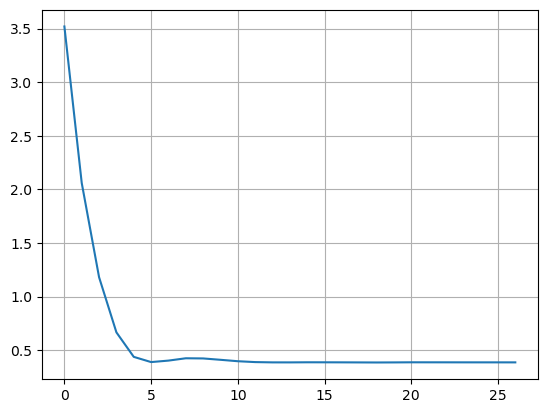

In [18]:
# График ошибки
plt.plot(model_matrix_MLP.loss_curve_)
plt.grid(True)
plt.show()

In [19]:
# Предсказание нейросети
preds_matrix_MLP_train = model_matrix_MLP.predict(X_matrix_train)
preds_matrix_MLP_test = model_matrix_MLP.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_MLP_train = mean_absolute_error(y_matrix_train, preds_matrix_MLP_train)
MSE_matrix_MLP_train = mean_squared_error (y_matrix_train, preds_matrix_MLP_train)
r2_matrix_MLP_train = r2_score(y_matrix_train, preds_matrix_MLP_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_MLP_train) 
print('MSE_train:', MSE_matrix_MLP_train) 
print('r2_train', r2_matrix_MLP_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_MLP_test = mean_absolute_error(y_matrix_test, preds_matrix_MLP_test)
MSE_matrix_MLP_test = mean_squared_error (y_matrix_test, preds_matrix_MLP_test)
r2_matrix_MLP_test = r2_score(y_matrix_test, preds_matrix_MLP_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_MLP_test) 
print('MSE_train:', MSE_matrix_MLP_test) 
print('r2_train', r2_matrix_MLP_test)

Точность модели на тренировочных данных
MAE_train: 0.6994172083890544
MSE_train: 0.7777943851090413
r2_train 0.000939171018648266

Точность модели на тестовых данных
MAE_train: 0.7455791949598586
MSE_train: 0.8433946075070669
r2_train -0.010828183753924803


Значение коэффициента детерминации близки к нулю. Нейросеть не справилась с задачей. Возможно получилось бы улучшить метрики с помощью подбора параметров

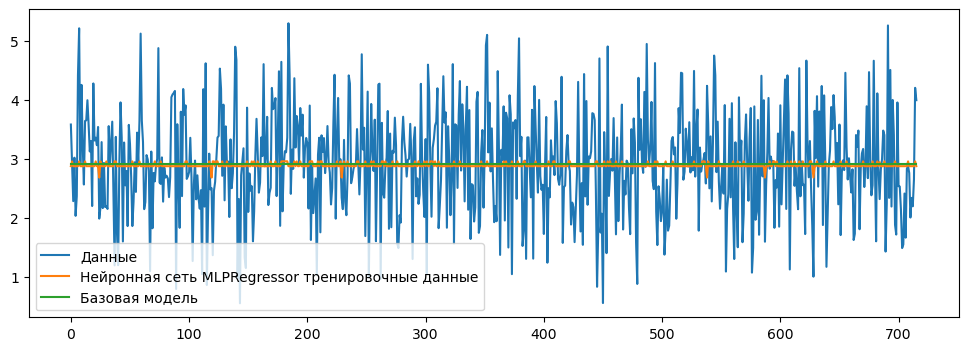

In [20]:
# Визуализация для тренировочной выборки
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_matrix_train.values, label='Данные')
ax.plot(preds_matrix_MLP_train, label='Нейронная сеть MLPRegressor тренировочные данные')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

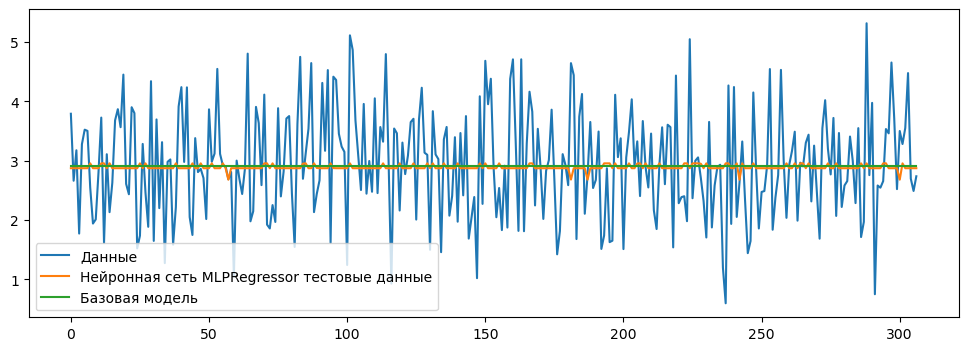

In [21]:
# Визуализация для тестовой выборки
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_matrix_test.values, label='Данные')
ax.plot(preds_matrix_MLP_test, label='Нейронная сеть MLPRegressor тестовые данные')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Построение линейной модели нейронной сети с помощью библиотеки TensorFlow

Нейронная сеть с двумя скрытыми слоями по 8 нейронов

In [22]:
def baseline_model():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [23]:
model1 = baseline_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
history = model1.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 34ms/step - loss: 2.3656 - val_loss: 0.8275
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8383 - val_loss: 0.7440
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.8137 - val_loss: 0.7361
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7996 - val_loss: 0.7438
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8010 - val_loss: 0.7350
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7990 - val_loss: 0.7344
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8012 - val_loss: 0.7346
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 0.7999 - val_loss: 0.7344
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7990 - val_loss: 0.7391
Epoch 10/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7981 - val_loss: 0.7352


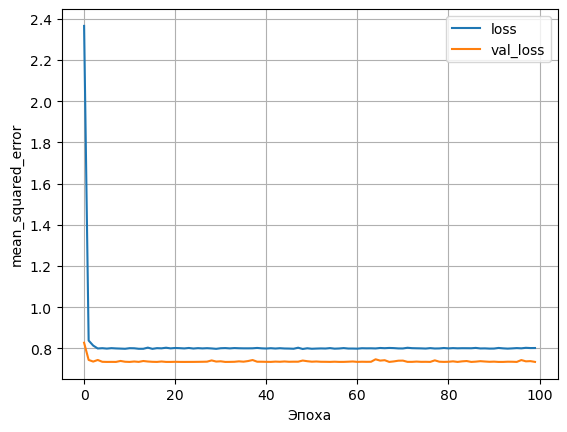

In [25]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [26]:
# Проверяем точность сети на тестовых данных
train_rezult = model1.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model1.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 5ms/step - loss: 0.8398


In [27]:
# Предсказание нейросети
preds_matrix_model1_train = model1.predict(X_matrix_train)
preds_matrix_model1_test = model1.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_train = mean_absolute_error(y_matrix_train.values, preds_matrix_model1_train)
MSE_matrix_model1_train = mean_squared_error (y_matrix_train.values, preds_matrix_model1_train)
r2_matrix_model1_train = r2_score(y_matrix_train.values, preds_matrix_model1_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model1_train) 
print('MSE_train:', MSE_matrix_model1_train) 
print('r2_train', r2_matrix_model1_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model1_test = mean_absolute_error(y_matrix_test.values, preds_matrix_model1_test)
MSE_matrix_model1_test = mean_squared_error (y_matrix_test.values, preds_matrix_model1_test)
r2_matrix_model1_test = r2_score(y_matrix_test.values, preds_matrix_model1_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model1_test) 
print('MSE_train:', MSE_matrix_model1_test) 
print('r2_train', r2_matrix_model1_test)

10/10 [==============================] - 0s 3ms/step
Точность модели на тренировочных данных
MAE_train: 0.7009916050974854
MSE_train: 0.7786996492376219
r2_train -0.00022362206402504192

Точность модели на тестовых данных
MAE_train: 0.7457129677704246
MSE_train: 0.8398491954558126
r2_train -0.0065789244006766445


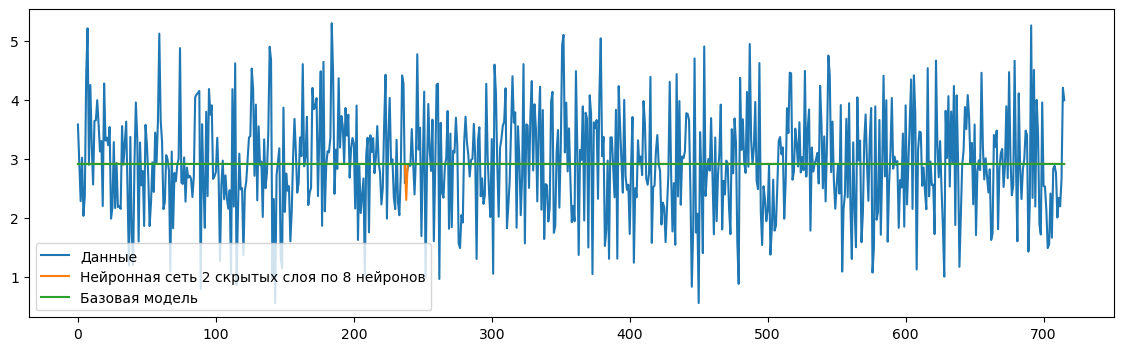

In [28]:
# Визуализация на обучающих данных данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Данные')
ax.plot(preds_matrix_model1_train, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

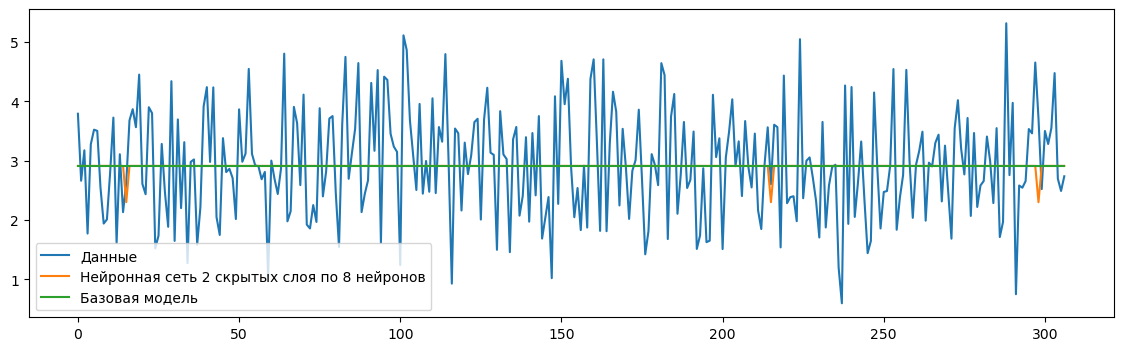

In [29]:
# Визуализация на тестовых данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Данные')
ax.plot(preds_matrix_model1_test, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Нейронная сеть с 6 скрытыми слоями по 8 нейронов

In [30]:
def baseline_model():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [31]:
model2 = baseline_model()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 104       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 dense_9 (Dense)             (None, 1)                

In [32]:
%%time
history = model2.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=150)

Epoch 1/150
16/16 [==============================] - 2s 45ms/step - loss: 2.8889 - val_loss: 0.7775
Epoch 2/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8167 - val_loss: 0.7344
Epoch 3/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8026 - val_loss: 0.7346
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8014 - val_loss: 0.7364
Epoch 5/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8003 - val_loss: 0.7356
Epoch 6/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8013 - val_loss: 0.7344
Epoch 7/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8026 - val_loss: 0.7354
Epoch 8/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8011 - val_loss: 0.7345
Epoch 9/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8010 - val_loss: 0.7344
Epoch 10/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8017 - val_loss: 0.7344

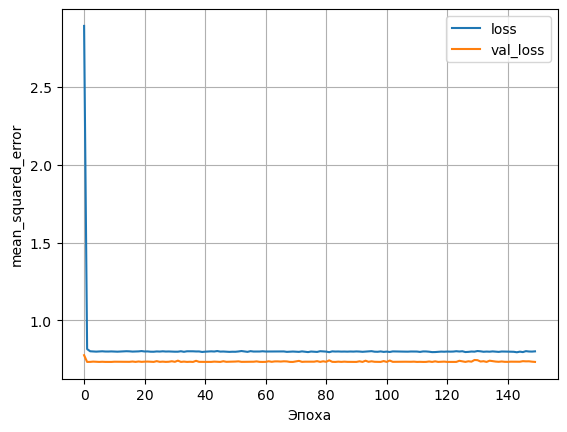

In [33]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [34]:
# Проверяем точность сети на тестовых данных
train_rezult = model2.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model2.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.8359


In [35]:
# Предсказание нейросети
preds_matrix_model2_train = model2.predict(X_matrix_train)
preds_matrix_model2_test = model2.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model2_train = mean_absolute_error(y_matrix_train, preds_matrix_model2_train)
MSE_matrix_model2_train = mean_squared_error (y_matrix_train, preds_matrix_model2_train)
r2_matrix_model2_train = r2_score(y_matrix_train, preds_matrix_model2_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model2_train) 
print('MSE_train:', MSE_matrix_model2_train) 
print('r2_train', r2_matrix_model2_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model2_test = mean_absolute_error(y_matrix_test, preds_matrix_model2_test)
MSE_matrix_model2_test = mean_squared_error (y_matrix_test, preds_matrix_model2_test)
r2_matrix_model2_test = r2_score(y_matrix_test, preds_matrix_model2_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model2_test) 
print('MSE_train:', MSE_matrix_model2_test) 
print('r2_train', r2_matrix_model2_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.7008072198122913
MSE_train: 0.7789494780706221
r2_train -0.0005445220419357799

Точность модели на тестовых данных
MAE_train: 0.7437078640272974
MSE_train: 0.8358930024442415
r2_train -0.001837334448747674


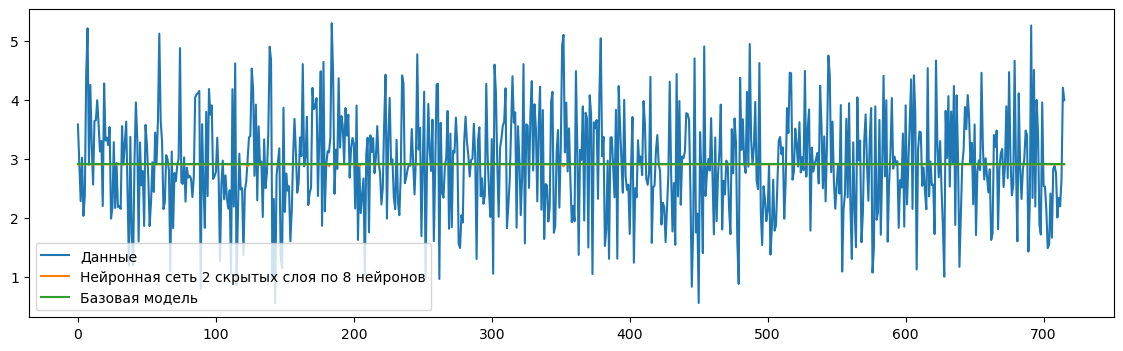

In [36]:
# Визуализация на обучающих данных данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Данные')
ax.plot(preds_matrix_model2_train, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

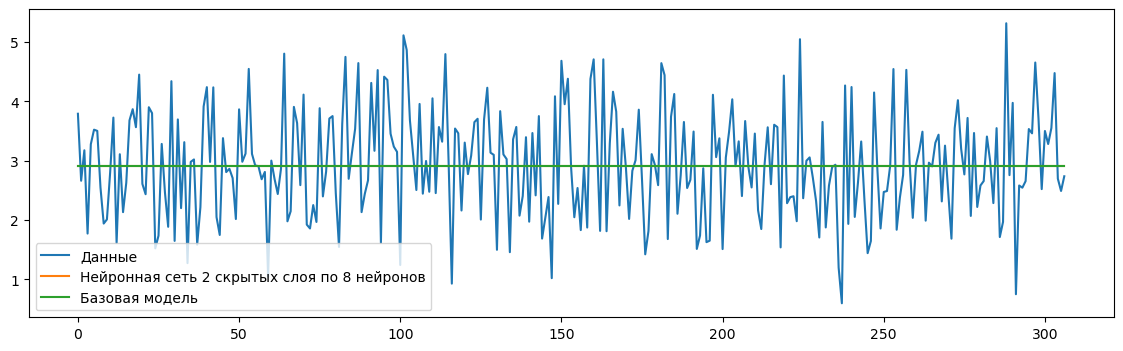

In [37]:
# Визуализация на тестовых данных
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Данные')
ax.plot(preds_matrix_model2_test, label='Нейронная сеть 2 скрытых слоя по 8 нейронов')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Нейронная сеть с шестью скрытыми слоями дала большее значение коэффициента детерминации

Создадим модель с добавлением слоев Dropout, чтобы модель не переучивалась

In [38]:
def baseline_model():
    model = keras.Sequential()
    model.add(Dense(8, input_dim=12 , activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [39]:
model3 = baseline_model()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 104       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 8)                

In [40]:
%%time
history = model3.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=150)

Epoch 1/150
16/16 [==============================] - 3s 42ms/step - loss: 3.7005 - val_loss: 0.8493
Epoch 2/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8868 - val_loss: 0.7344
Epoch 3/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8263 - val_loss: 0.7377
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8317 - val_loss: 0.7377
Epoch 5/150
16/16 [==============================] - 0s 11ms/step - loss: 0.7993 - val_loss: 0.7359
Epoch 6/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8426 - val_loss: 0.7485
Epoch 7/150
16/16 [==============================] - 0s 12ms/step - loss: 0.8535 - val_loss: 0.7368
Epoch 8/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8287 - val_loss: 0.7361
Epoch 9/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8144 - val_loss: 0.7447
Epoch 10/150
16/16 [==============================] - 0s 10ms/step - loss: 0.8304 - val_loss: 0.7379

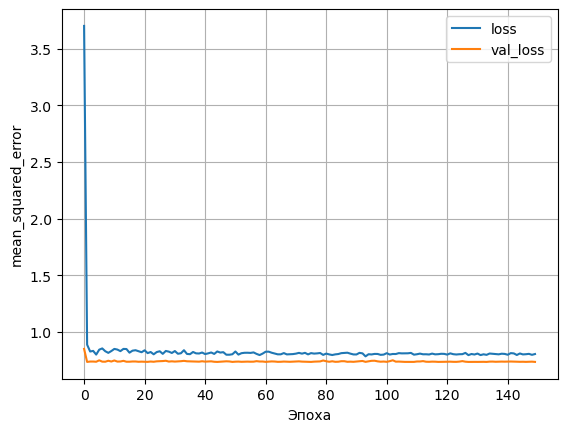

In [41]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [42]:
# Проверяем точность сети на данных
train_rezult = model3.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model3.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.8351


In [43]:
# Предсказание нейросети
preds_matrix_model3_train = model3.predict(X_matrix_train)
preds_matrix_model3_test = model3.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model3_train = mean_absolute_error(y_matrix_train, preds_matrix_model3_train)
MSE_matrix_model3_train = mean_squared_error (y_matrix_train, preds_matrix_model3_train)
r2_matrix_model3_train = r2_score(y_matrix_train, preds_matrix_model3_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model3_train) 
print('MSE_train:', MSE_matrix_model3_train) 
print('r2_train', r2_matrix_model3_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model3_test = mean_absolute_error(y_matrix_test, preds_matrix_model3_test)
MSE_matrix_model3_test = mean_squared_error (y_matrix_test, preds_matrix_model3_test)
r2_matrix_model3_test = r2_score(y_matrix_test, preds_matrix_model3_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model3_test) 
print('MSE_train:', MSE_matrix_model3_test) 
print('r2_train', r2_matrix_model3_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.7008976450782005
MSE_train: 0.7785277511206784
r2_train -2.8224818964250886e-06

Точность модели на тестовых данных
MAE_train: 0.7435522895715247
MSE_train: 0.8350662457006733
r2_train -0.000846447134472017


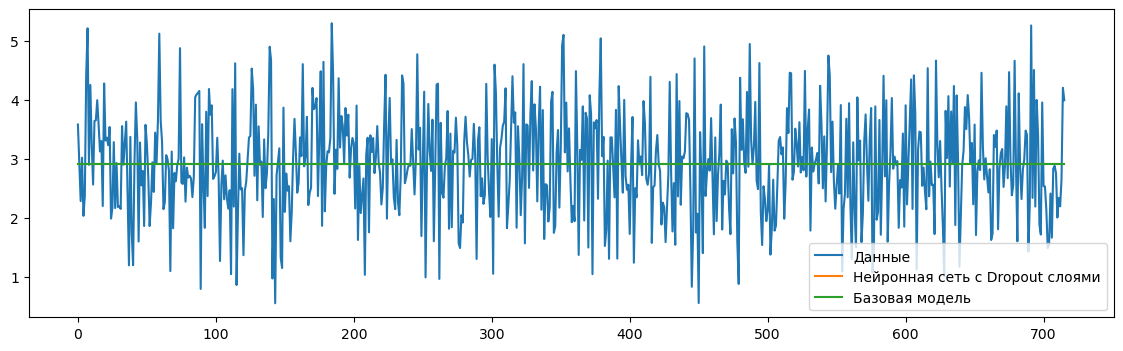

In [44]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Данные')
ax.plot(preds_matrix_model3_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

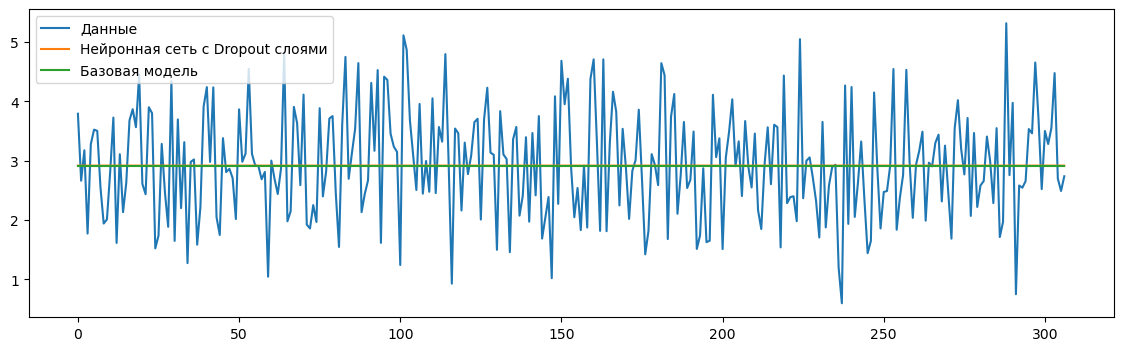

In [45]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Данные')
ax.plot(preds_matrix_model3_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Нейронная сеть со слоями дропаут дала результат лучше, чем без них. r2 на обучающих данных получилась положительной

Попробую увеличить количество нейронов в слоях

In [46]:
def baseline_model():
    model = keras.Sequential()
    model.add(Dense(24, input_dim=12 , activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [47]:
model4 = baseline_model()
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 24)                312       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_18 (Dense)            (None, 24)                600       
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_19 (Dense)            (None, 24)                600       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_20 (Dense)            (None, 24)               

In [48]:
%%time
history = model4.fit(
    X_matrix_train,
    y_matrix_train,
    validation_split=0.3,
    verbose=1, epochs=150)

Epoch 1/150
16/16 [==============================] - 6s 108ms/step - loss: 2.1596 - val_loss: 0.7484
Epoch 2/150
16/16 [==============================] - 0s 29ms/step - loss: 0.8417 - val_loss: 0.7375
Epoch 3/150
16/16 [==============================] - 0s 16ms/step - loss: 0.8558 - val_loss: 0.7675
Epoch 4/150
16/16 [==============================] - 0s 19ms/step - loss: 0.8456 - val_loss: 0.7726
Epoch 5/150
16/16 [==============================] - 0s 17ms/step - loss: 0.8367 - val_loss: 0.7426
Epoch 6/150
16/16 [==============================] - 0s 14ms/step - loss: 0.8488 - val_loss: 0.7392
Epoch 7/150
16/16 [==============================] - 0s 12ms/step - loss: 0.8338 - val_loss: 0.7360
Epoch 8/150
16/16 [==============================] - 0s 12ms/step - loss: 0.8306 - val_loss: 0.7354
Epoch 9/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8412 - val_loss: 0.7567
Epoch 10/150
16/16 [==============================] - 0s 11ms/step - loss: 0.8536 - val_loss: 0.749

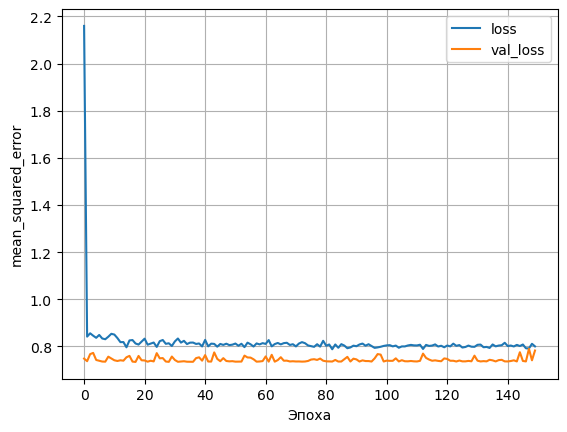

In [49]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [50]:
# Проверяем точность сети на данных
train_rezult = model4.evaluate(X_matrix_train, y_matrix_train)
test_rezult = model4.evaluate(X_matrix_test, y_matrix_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.8647


In [51]:
# Предсказание нейросети
preds_matrix_model4_train = model4.predict(X_matrix_train)
preds_matrix_model4_test = model4.predict(X_matrix_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model4_train = mean_absolute_error(y_matrix_train, preds_matrix_model4_train)
MSE_matrix_model4_train = mean_squared_error (y_matrix_train, preds_matrix_model4_train)
r2_matrix_model4_train = r2_score(y_matrix_train, preds_matrix_model4_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model4_train) 
print('MSE_train:', MSE_matrix_model4_train) 
print('r2_train', r2_matrix_model4_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model4_test = mean_absolute_error(y_matrix_test, preds_matrix_model4_test)
MSE_matrix_model4_test = mean_squared_error (y_matrix_test, preds_matrix_model4_test)
r2_matrix_model4_test = r2_score(y_matrix_test, preds_matrix_model4_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model4_test) 
print('MSE_train:', MSE_matrix_model4_test) 
print('r2_train', r2_matrix_model4_test)

10/10 [==============================] - 0s 4ms/step
Точность модели на тренировочных данных
MAE_train: 0.7267232237599381
MSE_train: 0.8169510119224985
r2_train -0.04935670767798417

Точность модели на тестовых данных
MAE_train: 0.7619870740762373
MSE_train: 0.8647366487940461
r2_train -0.03640711992413004


In [52]:
preds_matrix_model4_test = pd.DataFrame(preds_matrix_model4_test)
preds_matrix_model4_test.shape

(307, 1)

In [53]:
df_norm.head()

NameError: name 'df_norm' is not defined

In [ ]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_train.values, label='Данные')
ax.plot(preds_matrix_model4_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_test.values, label='Данные')
ax.plot(preds_matrix_model4_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Коэффициент детерминации для тестовой выборки положителен, но почти равен нулю

Созданим нейронную сеть со слоем нормализации. Будем использовать исходный датасет, который не масштабировался

In [ ]:
df.describe().T

In [ ]:
# Целевая переменная 'Соотношение матрица-наполнитель'
X_matrix_orig = df.copy()
y_matrix_orig = X_matrix_orig.pop('matrix_filler')
X_matrix_orig.shape, y_matrix_orig.shape

In [ ]:
X_matrix_orig.describe().T

In [ ]:
# Разделим на тренировочную и тестовую выборку для задачи с целевой переменной Соотношение матрица-наполнитель
X_matrix_orig_train, X_matrix_orig_test, y_matrix_orig_train, y_matrix_orig_test = train_test_split(X_matrix_orig,
                                                                                                    y_matrix_orig, 
                                                                                                    test_size=0.3,
                                                                                                    random_state=42)
print('X_matrix_orig_train:', X_matrix_orig_train.shape, 'y_matrix_orig_train:', y_matrix_orig_train.shape)
print('X_matrix_orig_test:', X_matrix_orig_test.shape, 'y_matrix_orig_test:', y_matrix_orig_test.shape)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(X_matrix_orig_train))

In [ ]:
print(normalizer.mean.numpy())

In [ ]:
X_matrix_orig_train.describe()

In [ ]:
def baseline_model(norm):
    model = keras.Sequential()
    model.add(normalizer)
    model.add(Dense(24, input_dim=12 , activation='tanh'))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

In [ ]:
model5 = baseline_model(normalizer)
model5.summary()

In [ ]:
%%time
history = model5.fit(
    X_matrix_orig_train,
    y_matrix_orig_train,
    validation_split=0.3,
    verbose=1, epochs=100)

In [ ]:
# График ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid(True)
plt.xlabel('Эпоха')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

Видно, что модель переобучена

In [ ]:
# Проверяем точность сети на тренировочных и тестовых данных
train_rezult = model5.evaluate(X_matrix_orig_train, y_matrix_orig_train)
test_rezult = model5.evaluate(X_matrix_orig_test, y_matrix_orig_test)

In [ ]:
# Предсказание нейросети
preds_matrix_model5_train = model5.predict(X_matrix_orig_train)
preds_matrix_model5_test = model5.predict(X_matrix_orig_test)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model5_train = mean_absolute_error(y_matrix_orig_train, preds_matrix_model5_train)
MSE_matrix_model5_train = mean_squared_error (y_matrix_orig_train, preds_matrix_model5_train)
r2_matrix_model5_train = r2_score(y_matrix_orig_train, preds_matrix_model5_train)
print('Точность модели на тренировочных данных')
print('MAE_train:', MAE_matrix_model5_train) 
print('MSE_train:', MSE_matrix_model5_train) 
print('r2_train', r2_matrix_model5_train)

# Оцениваем точность модели на тренировочной выборке
MAE_matrix_model5_test = mean_absolute_error(y_matrix_orig_test, preds_matrix_model5_test)
MSE_matrix_model5_test = mean_squared_error (y_matrix_orig_test, preds_matrix_model5_test)
r2_matrix_model5_test = r2_score(y_matrix_orig_test, preds_matrix_model5_test)
print('')
print('Точность модели на тестовых данных')
print('MAE_train:', MAE_matrix_model5_test) 
print('MSE_train:', MSE_matrix_model5_test) 
print('r2_train', r2_matrix_model5_test)

In [ ]:
# Визуализация на обучающих данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_orig_train.values, label='Данные')
ax.plot(preds_matrix_model5_train, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_train, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# Визуализация на тестовых данных данных 
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_matrix_orig_test.values, label='Данные')
ax.plot(preds_matrix_model5_test, label='Нейронная сеть с Dropout слоями')
ax.plot(preds_matrix_dum_test, label='Базовая модель')
ax.legend()
plt.show()

Точность на тестовой выборке значительно лучше, чем в других нейросетях, но на тестовой выборке результат немного худе, чем у модели 4

Сравнение нейросетей по метрикам

In [ ]:
# Сравниваем наши модели по метрикам для тренировочной и тестовой выборки
metrics_df = {'Регрессор': ['DummerRegressor', 'MLPRegressor', 'NS 2 слоя по 8 нейронов',  'NS 6 слоев по 8 нейронов',
                            'NS 6 слоев по 8 нейронов + Dropout', 'NS 6 слоев по 24 нейронa + Dropout',
                            'NS 6 слоев по 24 нейронa + Dropout + norm'], 
         'r2_train': [r2_matrix_dum_train, r2_matrix_MLP_train, r2_matrix_model1_train, r2_matrix_model2_train,
                     r2_matrix_model3_train, r2_matrix_model4_train, r2_matrix_model5_train],
         'MAE_train': [MAE_matrix_dum_train, MAE_matrix_MLP_train, MAE_matrix_model1_train, MAE_matrix_model2_train,
                      MAE_matrix_model3_train, MAE_matrix_model4_train, MAE_matrix_model5_train],
         'MSE_train': [MSE_matrix_dum_train, MSE_matrix_MLP_train, MSE_matrix_model1_train, MSE_matrix_model2_train,
                      MSE_matrix_model3_train, MSE_matrix_model4_train, MSE_matrix_model5_train],
        'r2_test': [r2_matrix_dum_test, r2_matrix_MLP_test, r2_matrix_model1_test,  r2_matrix_model2_test,
                    r2_matrix_model3_test,  r2_matrix_model4_test,  r2_matrix_model5_test],
         'MAE_test': [MAE_matrix_dum_test, MAE_matrix_MLP_test, MAE_matrix_model1_test, MAE_matrix_model2_test,
                     MAE_matrix_model3_test, MAE_matrix_model4_test, MAE_matrix_model5_test],
         'MSE_test': [MSE_matrix_dum_test, MSE_matrix_MLP_test, MSE_matrix_model1_test, MSE_matrix_model2_test,
                     MSE_matrix_model3_test, MSE_matrix_model4_test, MSE_matrix_model5_test]
         } 

metrics_df = pd.DataFrame(metrics_df)
metrics_df

Нейросети из библиотеки Tensorflow старались подстроитьс под данные, но метрики разочаровывают. Лучшая обобщающая способность на тестовой выборке оказаласть у нейросети с 6 слоями по 8 нейронов, но и она предсказывает хуже базовой модели

In [ ]:
# Перевод предсказанных данных из нормализованных в исходные

result_reverse = minmax_scaler.inverse_transform(preds_matrix_model2_test)
initial_data = pd.DataFrame(result_reverse)
initial_data